**This project applies a convolutional autoencoder to extract a reduced number of critical features of time-series signals and then use these reduced number of features as the input for machine learning algorithms to classify each signal.**

### 1. Import all the requiered libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import keras

from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


### 2. Explore and prepare the dataset

In [2]:
df = pd.read_csv("Synthetic control chart time series data.csv", header=None)

In [3]:
df.shape

(300, 60)

In [4]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,28.7812,34.4632,31.3381,31.2834,28.9207,33.7596,25.3969,27.7849,35.2479,27.1159,...,31.4333,24.5556,33.7431,25.0466,34.9318,34.9879,32.4721,33.3759,25.4652,25.8717
1,24.8923,25.7410,27.5532,32.8217,27.8789,31.5926,31.4861,35.5469,27.9516,31.6595,...,32.5577,31.0205,26.6418,28.4331,33.6564,26.4244,28.4661,34.2484,32.1005,26.6910
2,31.3987,30.6316,26.3983,24.2905,27.8613,28.5491,24.9717,32.4358,25.2239,27.3068,...,33.6318,26.5966,25.5387,32.5434,25.5772,29.9897,31.3510,33.9002,29.5446,29.3430
3,25.7740,30.5262,35.4209,25.6033,27.9700,25.2702,28.1320,29.4268,31.4549,27.3200,...,34.6292,28.7261,28.2979,31.5787,34.6156,32.5492,30.9827,24.8938,27.3659,25.3069
4,27.1798,29.2498,33.6928,25.6264,24.6555,28.9446,35.7980,34.9446,24.5596,34.2366,...,27.7218,27.9601,35.7198,27.5760,35.3375,29.9993,34.2149,33.1276,31.1057,31.0179


In [5]:
df.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    0
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
dtype: int64

**There are not blank cells or empty values and a total of 300 synthetic control chart time-series signals, each one with a length of 60 steps. Besides, there are three classes in the dataset: (1) from index 0 to 99 the signal class is Normal, (2) from index 100 to 199 the signal class is Cyclic, and (3) from index 200 to 299 the signal class is Upward shift. Lets visualize some of the signals!**

In [6]:
normal = pd.merge(df.iloc[0], df.iloc[4], right_index = True, left_index = True)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

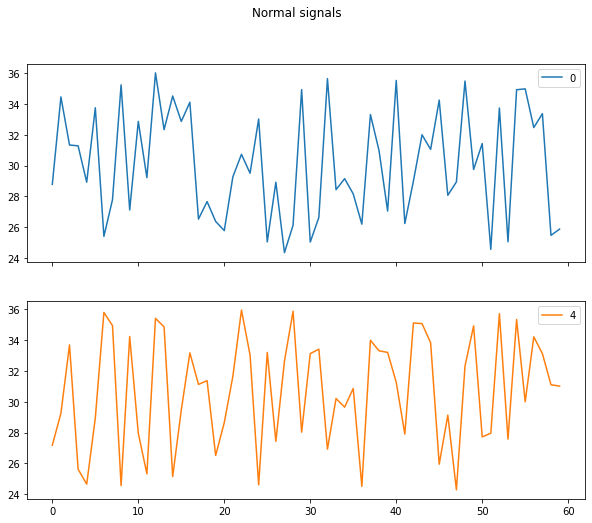

In [7]:
normal.plot(kind='line', figsize=(10,8), subplots=True, title='Normal signals')

In [8]:
cyclic = pd.merge(df.iloc[120], df.iloc[190], right_index = True, left_index = True)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

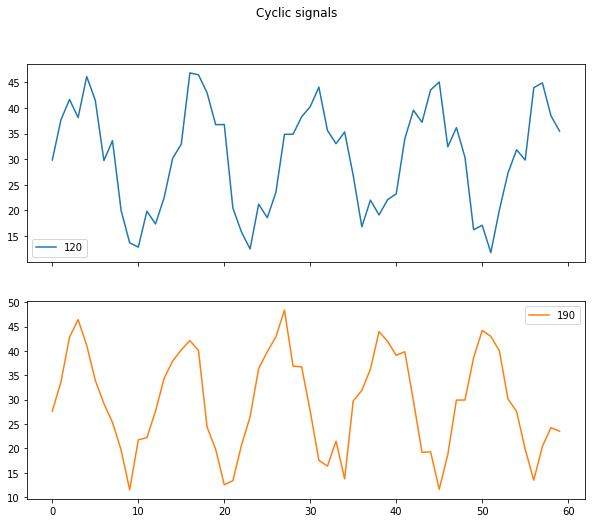

In [9]:
cyclic.plot(kind='line', figsize=(10,8), subplots=True, title='Cyclic signals')

In [10]:
upward_shift = pd.merge(df.iloc[231], df.iloc[264], right_index = True, left_index = True)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

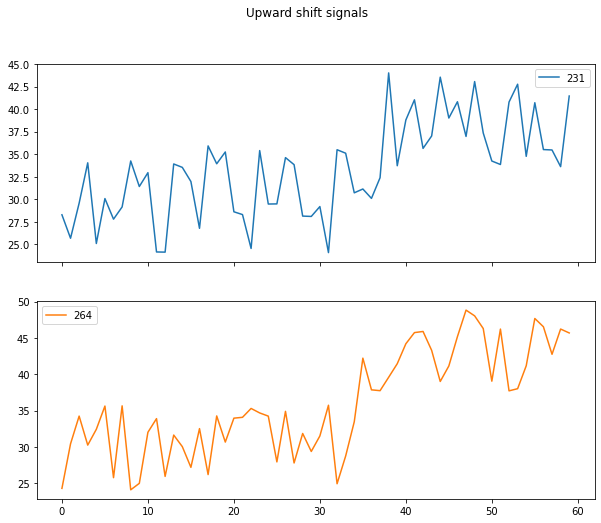

In [11]:
upward_shift.plot(kind='line', figsize=(10,8), subplots=True, title='Upward shift signals')

**The dataset contains 100 samples for each class. Therefore, the training and testing set will be split with a 7:3 rule. This means that each class will have 70 signals for training and 30 signals for testing.**

In [12]:
normal_train   = df[0:70]
normal_test    = df[70:100]
cyclic_train   = df[100:170]
cyclic_test    = df[170:200]
upward_train = df[200:270]
upward_test  = df[270:300]

print("Normal signal train shape:", normal_train.shape)
print("Normal signal test shape :", normal_test.shape)
print('....')
print("Cyclic signal train shape :", cyclic_train.shape)
print("Cyclic signal test shape :", cyclic_test.shape)
print('....')
print("Upward shift train shape :", upward_train.shape)
print("Upward shift test shape :", upward_test.shape)

Normal signal train shape: (70, 60)
Normal signal test shape : (30, 60)
....
Cyclic signal train shape : (70, 60)
Cyclic signal test shape : (30, 60)
....
Upward shift train shape : (70, 60)
Upward shift test shape : (30, 60)


**Lets create our TRAINING set!**

In [13]:
train = np.vstack((normal_train, cyclic_train, upward_train))
print(train.shape)
train = np.reshape(train,[210, 60, 1])
print(train.shape)

# label 0 refers to normal, 1 to cyclic, and 2 to upward.
train_label = np.zeros([210,])
train_label[70:140] = 1
train_label[140:210] = 2
print(train_label.shape)

(210, 60)
(210, 60, 1)
(210,)


**Lets create our TESTING set!**

In [14]:
test = np.vstack((normal_test, cyclic_test, upward_test))
print(test.shape)
test = np.reshape(test,[90, 60, 1])
print(test.shape)
# label 0 refers to normal, 1 to cyclic, and 2 to upward.
test_label = np.zeros([90,])
test_label[30:60] = 1
test_label[60:90] = 2
print(test_label.shape)

(90, 60)
(90, 60, 1)
(90,)


### 3. Build the convolutional autoencoder

In [15]:
#set up model
model = Sequential()

input_snl = Input(shape=(60,1))
x = Conv1D(128, kernel_size=(3), padding='same', activation='relu', strides=1)(input_snl)
x = MaxPooling1D((2), padding='same')(x)
x = Conv1D(64, kernel_size=(3), padding='same', activation='relu', strides=1)(x)
x = MaxPooling1D((2), padding='same')(x)
x = Conv1D(32, kernel_size=(3), padding='same', activation='relu', strides=1)(x)
x = MaxPooling1D((2), padding='same')(x)
x = Conv1D(16, kernel_size=(3), padding='same', activation='relu', strides=1)(x)
x = MaxPooling1D((2), padding='same')(x)
x = Conv1D(1, kernel_size=(3), padding='same', activation='relu', strides=1)(x)
encoded = MaxPooling1D((2), padding='same')(x)

x = Conv1D(16, kernel_size=(3), padding='same', activation='relu', strides=1)(encoded)
x = UpSampling1D((2))(x)
x = Conv1D(32, kernel_size=(3), padding='same', activation='relu', strides=1)(x)
x = UpSampling1D((3))(x)
x = Conv1D(64, kernel_size=(3), padding='same', activation='relu', strides=1)(x)
x = UpSampling1D((5))(x)
x = Conv1D(128, kernel_size=(3), padding='same', activation='relu', strides=1)(x)
decoded =Conv1D(1, kernel_size=(3), padding='same', activation='relu', strides=1)(x)

autoencoder = Model(input_snl, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 60, 128)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 64)            24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 32)            6176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 32)             0     

### 4. Build an encoder with 2 features output

**Because the autoencoder is composed of two parts: (1) an encoder, and (2) a decoder, and the output of our autoencoder is the completed decoded features, it is required to also build the encoder that outputs the reduced encoded features of the autoencoder's encoder.**

In [16]:
encoder = Model(input_snl, encoded)

### 5. Train the convolutional autoencoder 

In [17]:
#fit model
autoencoder.fit(train, train_label, epochs=100, batch_size=30, shuffle=True)

Epoch 1/100
7/7 [==============================] - 2s 18ms/step - loss: 1.0313
Epoch 2/100
7/7 [==============================] - 0s 16ms/step - loss: 0.4902
Epoch 3/100
7/7 [==============================] - 0s 17ms/step - loss: 0.4173
Epoch 4/100
7/7 [==============================] - 0s 16ms/step - loss: 0.3591
Epoch 5/100
7/7 [==============================] - 0s 16ms/step - loss: 0.2848
Epoch 6/100
7/7 [==============================] - 0s 16ms/step - loss: 0.2850
Epoch 7/100
7/7 [==============================] - 0s 14ms/step - loss: 0.2065
Epoch 8/100
7/7 [==============================] - 0s 14ms/step - loss: 0.1543
Epoch 9/100
7/7 [==============================] - 0s 15ms/step - loss: 0.1572
Epoch 10/100
7/7 [==============================] - 0s 15ms/step - loss: 0.1470
Epoch 11/100
7/7 [==============================] - 0s 15ms/step - loss: 0.1220
Epoch 12/100
7/7 [==============================] - 0s 14ms/step - loss: 0.1217
Epoch 13/100
7/7 [==============================]

**Now that our autoencoder is trained, including its encoder part, we can encode all our signals, reducing their features from 60 to only 2. Lets do that for the training and testing set.**

### 6. Make predictions with our encoder

In [18]:
# training set
print('The shape of the initial training signals: ', train.shape)
encoded_snls = encoder.predict(train)
print('The shape of the encoded training signals: ', encoded_snls.shape)
encoded_snls = np.reshape(encoded_snls, [210, 2])

The shape of the initial training signals:  (210, 60, 1)
The shape of the encoded training signals:  (210, 2, 1)


In [19]:
# testing set
print('The shape of the initial testing signals: ', test.shape)
extract = encoder.predict(test)
print('The shape of the encoded testing signals: ', extract.shape)
extract = np.reshape(extract, [90, 2])

The shape of the initial testing signals:  (90, 60, 1)
The shape of the encoded testing signals:  (90, 2, 1)


### 7. Visualization of the 2 unique features

**Training set**

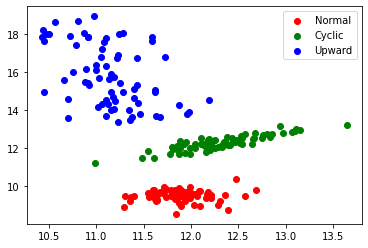

In [20]:
plt.scatter(encoded_snls[0:70,0],encoded_snls[0:70,1], color='red', label='Normal')
plt.scatter(encoded_snls[70:140,0],encoded_snls[70:140,1], color='green', label='Cyclic')
plt.scatter(encoded_snls[140:210,0],encoded_snls[140:210,1], color='blue', label='Upward')

plt.legend(loc='upper right')
plt.show()

**Testing set**

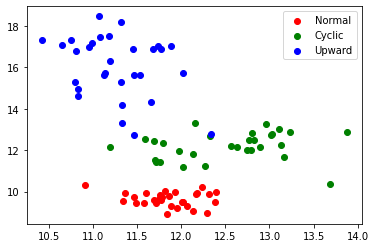

In [21]:
plt.scatter(extract[0:30,0],extract[0:30,1],color='red',label='Normal')
plt.scatter(extract[30:60,0],extract[30:60,1],color='green',label='Cyclic')
plt.scatter(extract[60:90,0],extract[60:90,1],color='blue',label='Upward')

plt.legend(loc='upper right')
plt.show()

**We can appreciate that by visualizing these two features, we are able to differentiate very accurately between the three types of signals. Probably, the traditional machine learning models that we will try as classifiers will be very accurate too.**

### 8. Support Vector Machine algorithm

**Let's first train our classification model with the training set!**

In [22]:
svm = SVC(kernel='linear', C=100)
svm.fit(encoded_snls, train_label)

SVC(C=100, kernel='linear')

**With our trained model let's do predictions of our testing set!**

In [23]:
predictions = svm.predict(extract)

In [24]:
predictions

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.])

**Let's evaluate if our classification model is able to classify the signals correctly even though they consist only of two features instead of the 60 time-steps.**

In [25]:
conf_mat = confusion_matrix(y_true=test_label, y_pred=predictions)
conf_mat

array([[30,  0,  0],
       [ 1, 28,  1],
       [ 0,  2, 28]], dtype=int64)

**Indeed, the confusion matrix figure shows that all the 90 signals were classified correctly. SVM algorithm achieves a 96% classification accuracy by taking only two features as input.**

<AxesSubplot:>

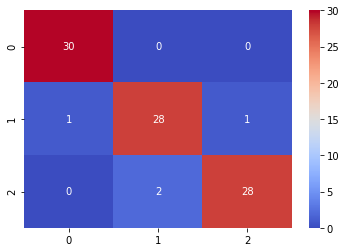

In [26]:
sns.heatmap(conf_mat, annot=True, cmap='coolwarm')

### 9. Random Forest algorithm

In [27]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None)
rf.fit(encoded_snls, train_label)

RandomForestClassifier()

In [28]:
predictions_rf = rf.predict(extract)
predictions_rf

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.])

<AxesSubplot:>

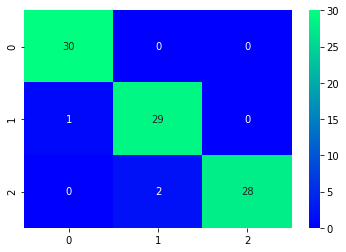

In [29]:
conf_mat_rf = confusion_matrix(y_true=test_label, y_pred=predictions_rf)
sns.heatmap(conf_mat_rf, annot=True, cmap='winter')

**The confusion matrix figure shows that almost all the 90 signals were classified correctly. Random Forest algorithm achieves a 97% classification accuracy by taking only two features as input.**

### 10. Logistic Regression algorithm

In [30]:
lr = LogisticRegression(C=1)
lr.fit(encoded_snls, train_label)

LogisticRegression(C=1)

In [31]:
predictions_lr = lr.predict(extract)
predictions_lr

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2.,
       2., 2., 2., 2., 2.])

<AxesSubplot:>

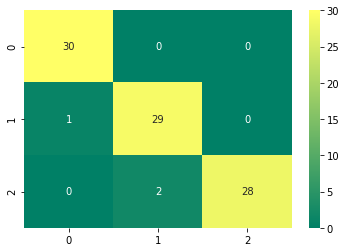

In [32]:
conf_mat_lr = confusion_matrix(y_true=test_label, y_pred=predictions_lr)
sns.heatmap(conf_mat_lr, annot=True, cmap='summer')

**The confusion matrix figure shows that almost all the 90 signals were classified correctly. Logistic Regression algorithm achieves a 97% classification accuracy by taking only two features as input.**

**We can conclude that the encoder part of our autoencoder does a good job by reducing the 60 initial features of the signals to only 2. With only 2 features, three different algorithms, SVM, Random Forest, and Logistic Regression, are able to classify almost perfectly, the different classes of signals.**